## Description

In this notebook, we compare the outcomes of different approaches to annotation of spectra of lipids in the context of MS imaging:  
  - Accurate mass matching in the average spectrum (a commonly used approach)
  - Matching theoretical spectra to the average spectrum using `masserstein` 
  - Deconvolving each pixel independently with `masserstein`  
  
We use a custom set of lipid formulas downloaded from LIPID MAPS data base. The set of lipids is supplied with the notebook.  

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
from venn import venn
from additional_functions import profile_ion_image, centroided_ion_image

In [3]:
import numpy.random as rd

In [4]:
analyzed_mass_range = (700, 900)

Load the centroided MS images calculated in Notebook 2:

In [5]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [6]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [7]:
images = [cerebellum_centroided_image, bladder_centroided_image]
shapes = [cerebellum_image_shape, bladder_image_shape]
names = ['cerebellum', 'bladder']

In [8]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [9]:
raw_images = [cerebellum_profile_image, bladder_profile_image]

Load the average spectra calculated in Notebook 2:

In [10]:
average_spectra = []
average_spectrum_masses = []
for i, n in enumerate(names):
    sp = open(n + '_centroided_average_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(mz), float(intsy)) for mz, intsy in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    average_spectra.append(sp)
    average_spectrum_masses.append([x[0] for x in sp.confs])

<IPython.core.display.Javascript object>


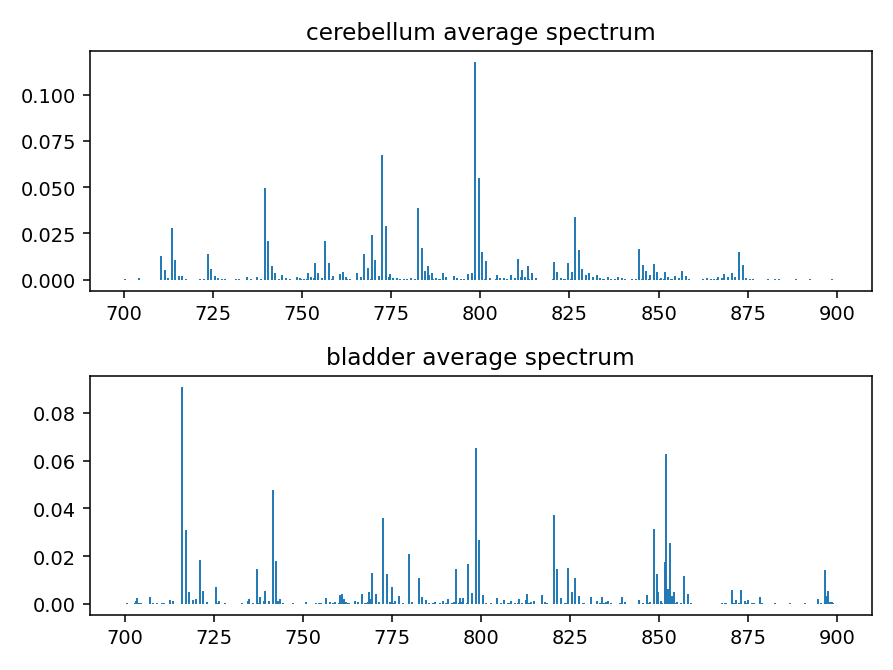

In [11]:
plt.figure()
for i, n in enumerate(names):
    plt.subplot(211+i)
    plt.title(n + ' average spectrum')
    average_spectra[i].plot()
plt.tight_layout()

Load the lipid formulas:

In [12]:
lipid_formulas = []
formula_to_subclasses = {}
formula_to_classes = {}
formula_to_IDs = {}
with open('selected_lipids_28032022.tsv') as h:
    for l in h:
        l = l.strip().split('\t')
        formula = l[3] 
        lipid_class = l[1]
        lipid_subclass = l[2]
        lipid_ID = l[0]
        if set(formula).issubset(set('CHNOP0123456789')):
            lipid_formulas.append(formula)
            try:
                formula_to_subclasses[formula].append(lipid_subclass)
            except KeyError:
                formula_to_subclasses[formula] = [lipid_subclass]
            try:
                formula_to_classes[formula].append(lipid_class)
            except KeyError:
                formula_to_classes[formula] = [lipid_class]
            try:
                formula_to_IDs[formula].append(lipid_ID)
            except KeyError:
                formula_to_IDs[formula] = [lipid_ID]
lipid_formulas = list(set(lipid_formulas))
nb_of_classes = len(set([x for formula in formula_to_classes for x in formula_to_classes[formula]]))
nb_of_subclasses = len(set([x for formula in formula_to_subclasses for x in formula_to_subclasses[formula]]))
nb_of_IDs = len(set([x for formula in formula_to_IDs for x in formula_to_IDs[formula]]))
print('Loaded %i unique lipid formulas' % len(lipid_formulas))
print('Loaded %i unique lipid classes' % nb_of_classes)
print('Loaded %i unique lipid subclasses' % nb_of_subclasses)
print('Loaded %i unique lipid IDs' % nb_of_IDs)

Loaded 3523 unique lipid formulas
Loaded 2 unique lipid classes
Loaded 30 unique lipid subclasses
Loaded 14454 unique lipid IDs


Generate the lipid reference spectra (assuming a potassium adduct). We'll take the peaks that are at least 5% as high as the highest one.  

In [13]:
lipid_spectra = [Spectrum(formula=f, adduct='K', threshold=0.05) for f in lipid_formulas]
for s in lipid_spectra: 
    s.normalize()

We'll discard the spectra that are outside of our desired mass range

In [14]:
is_mass_within_range = [analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1] for s in lipid_spectra]
lipid_spectra = [s for t, s in zip(is_mass_within_range, lipid_spectra) if t]
lipid_formulas = [s for t, s in zip(is_mass_within_range, lipid_formulas) if t]
assert all(s.formula == f for s,f in zip(lipid_spectra, lipid_formulas))

formula_to_subclasses = {f: formula_to_subclasses[f] for f in lipid_formulas}
formula_to_classes = {f: formula_to_classes[f] for f in lipid_formulas}
formula_to_IDs = {f: formula_to_IDs[f] for f in lipid_formulas}

nb_of_classes = len(set([x for formula in formula_to_classes for x in formula_to_classes[formula]]))
nb_of_subclasses = len(set([x for formula in formula_to_subclasses for x in formula_to_subclasses[formula]]))
nb_of_IDs = len(set([x for formula in formula_to_IDs for x in formula_to_IDs[formula]]))

print('Retained %i lipid spectra' % len(lipid_spectra))
print('Retained %i classes' % nb_of_classes)
print('Retained %i subclasses' % nb_of_subclasses)
print('Retained %i IDs' % nb_of_IDs)

Retained 1206 lipid spectra
Retained 2 classes
Retained 22 subclasses
Retained 6922 IDs


Get the lipid classes corresponding to the remaining formulas:

Get the monoisotopic masses of our lipid ions:

In [15]:
lipid_masses = [s.confs[0][0] for s in lipid_spectra]

Get the positive control lipid spectra (we'll use them to check the deconvolution results)

In [16]:
control_lipid_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']
control_lipid_formulas = ['C40H80NO8P', 'C42H82NO8P', 'C46H84NO8P']
control_lipid_spectrum_ids = [lipid_formulas.index(f) for f in control_lipid_formulas]
assert all(lipid_spectra[i].formula == f for i,f in zip(control_lipid_spectrum_ids, control_lipid_formulas))

Example theoretical spectrum:

<IPython.core.display.Javascript object>


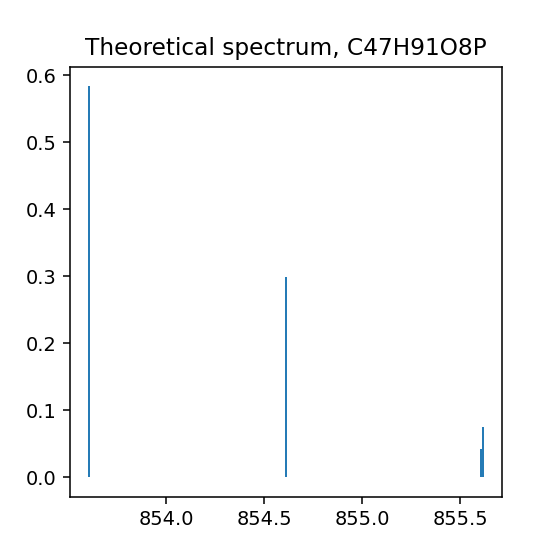

In [17]:
plt.figure(figsize=(4,4))
i = 1000
plt.title('Theoretical spectrum, %s' % lipid_spectra[i].formula)
lipid_spectra[i].plot()
plt.show()

## Mass matching accuracy settings

In [18]:
proportion_threshold = 1e-04
MTD = 0.005
MTD_th = 0.01

## Masserstein deconvolution of the average spectrum

In [19]:
proportions_in_average = []
regression_times = []
for i, sp in enumerate(average_spectra):
    s = time()
    regression = estimate_proportions(sp, lipid_spectra, MTD=MTD, MTD_th=MTD_th, MDC=1e-09, MMD=1.)
    e = time()
    proportions_in_average.append(regression['proportions'])
    regression_times.append(e-s)
print('Regression times:')
for n,t in zip(names, regression_times):
    print(n, round(t, 2), 'seconds')

Computing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 2096282.89it/s]
Splitting the experimental spectrum into chunks: 3207it [00:00, 2633861.94it/s]
Computing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1171/1171 [00:00<00:00, 3222788.70it/s]
Splitting the experimental spectrum into chunks: 423it [00:00, 2856989.68it/s]
Deconvolving chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.65it/s]

Regression times:
cerebellum 5.52 seconds
bladder 0.84 seconds


Note: MTD_th needs to be higher than MTD, otherwise the spectra can fit to "nothingness".   
MTD_th=0.005 gives us theoretical spectra without corresponding experimental signal.   
Another reason is that it's easier to get too much signal in the analyzed spectrum (due to noise) than to miss some signal (due to LOD).  

cerebellum


<IPython.core.display.Javascript object>


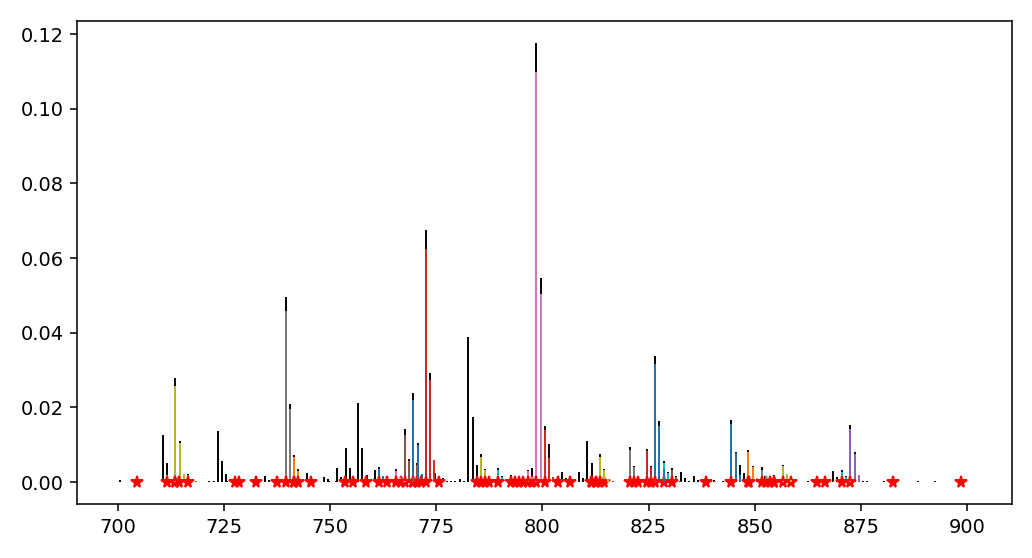

bladder


<IPython.core.display.Javascript object>


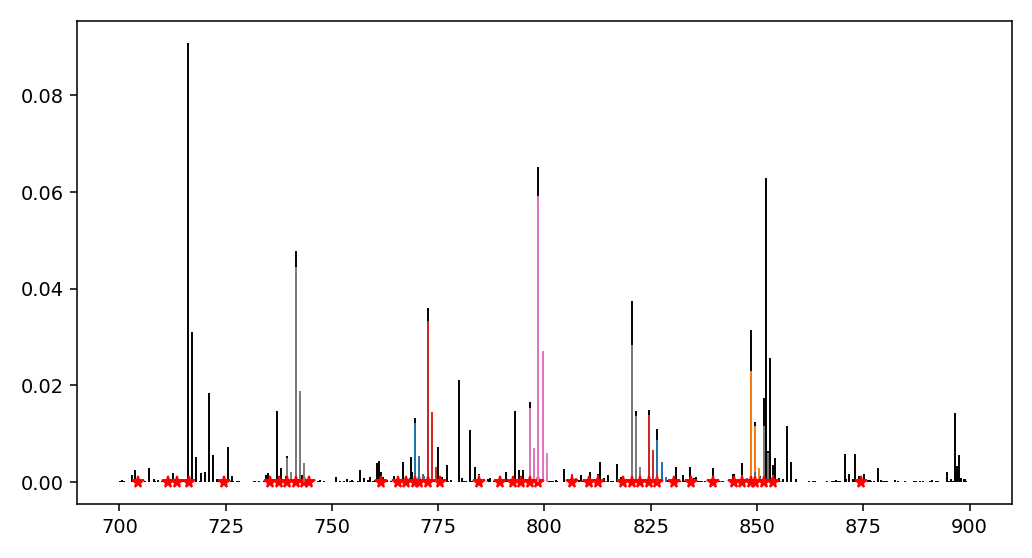

In [20]:
for i, n in enumerate(names):
    print(n)
    plt.figure(figsize=(7.4,4))
    average_spectra[i].plot(profile=False, color='k', show=False)
    for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_average[i]):
        if p > proportion_threshold:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.tight_layout()
    plt.savefig('Figs/peak_assignment/' + n + '_average_then_annotate_spectrum.png', dpi=300)
    plt.show()

In [21]:
for i,n in enumerate(names):
    with open(n + '_average_spectrum_annotation_results.tsv', 'w') as h:
        h.write('\t'.join(['Formula     ', 'Mass', 'Concentration']) + '\n')
        for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_average[i]):
            if p > proportion_threshold:
                h.write('\t'.join([s.formula, str(round(s.confs[0][0], 4)), str(round(p, 4))]) + '\n')

## Whole-image Masserstein deconvolution

In [22]:
proportions_in_whole = [np.zeros(len(lipid_spectra)) for _ in range(2)]
analyzed_pixels = [0, 0]
control_lipid_images = [np.zeros(shp + (3, )) for shp in shapes]

# total signal images for normalization purposes:
global_tic_images = [np.zeros(sh) for sh in shapes] 
local_tic_images = [np.zeros(sh) for sh in shapes] 

for im_id, img in enumerate(images):
    print('Processing image:', names[im_id])
    s = time()
    for idx, (xcoord,ycoord,zcoord) in enumerate(img.coordinates):
        if not idx % 10000:
            print('Processing pixel number', idx)
        if rd.rand() >= 0.25:  # taking a given proportion of pixels 
            continue
        else:
            analyzed_pixels[im_id] += 1
        mz, intsy = img.getspectrum(idx)
        ##  Get the total signal before truncation: 
        tic = np.sum(intsy)
        global_tic_images[im_id][ycoord-1, xcoord-1] = tic
        # Truncate to the selected mass range:
        selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
        mz = mz[selected_range]
        intsy = intsy[selected_range]
        ##  Get the total signal in the truncated region:
        local_tic = np.sum(intsy)
        local_tic_images[im_id][ycoord-1, xcoord-1] = local_tic
        pixel_spectrum = Spectrum(confs=list(zip(mz, intsy)))
        # Normalize for regression purposes
        pixel_spectrum.normalize()
        regression = estimate_proportions(pixel_spectrum, lipid_spectra, 
                                          MTD=MTD, MTD_th=MTD_th, MDC=1e-09, MMD=1, progress=False)
        pr_array = np.array(regression['proportions'])
        proportions_in_whole[im_id] += pr_array
        control_lipid_images[im_id][ycoord-1, xcoord-1, ...] = pr_array[control_lipid_spectrum_ids]
    e = time()
    print('Regression time:', e-s)

Processing image: cerebellum
Processing pixel number 0
Regression time: 204.5758056640625
Processing image: bladder
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Regression time: 1519.505341053009


In [23]:
assert np.all(local_tic_images[0] <= global_tic_images[0])
assert np.all(local_tic_images[1] <= global_tic_images[1])

In [24]:
for im_id in range(2):
    gim = global_tic_images[im_id]
    gim[gim==0] = 1
normalization_factors = [np.sum(local_tic_images[im_id]/global_tic_images[im_id]) for im_id in range(2)]

In [25]:
normalization_factors

[300.18479394095664, 3626.9269566963353]

Display the regression results for the control lipids, compare with their single peak images:

In [26]:
profile_bladder_images = []
profile_cerebellum_images = []
for s_id in control_lipid_spectrum_ids:
    s = lipid_spectra[s_id]
    mz = s.confs[0][0]
    profile_cerebellum_images.append(profile_ion_image(cerebellum_profile_image, mz))
    profile_bladder_images.append(profile_ion_image(bladder_profile_image, mz))

<IPython.core.display.Javascript object>


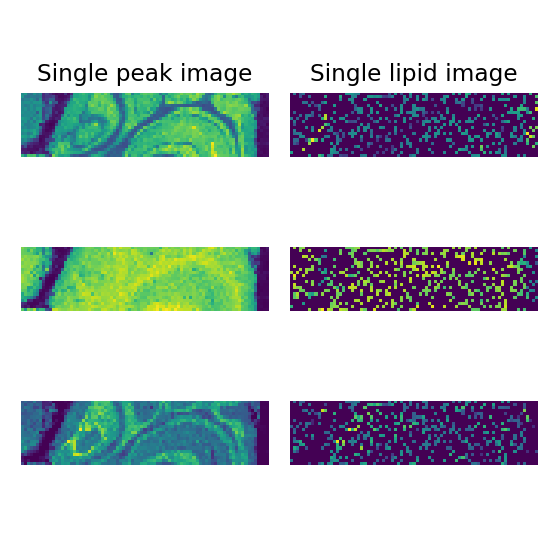

In [27]:
plt.figure(figsize=(4, 4))
plt.subplot(3, 2, 1)
plt.title('Single peak image')
plt.subplot(3, 2, 2)
plt.title('Single lipid image')
for i, n in enumerate(control_lipid_names):
    plt.subplot(3, 2, 1+2*i)
    plt.imshow(profile_cerebellum_images[i])
    plt.axis('off')
    plt.subplot(3, 2, 2+2*i)
    plt.imshow(control_lipid_images[0][..., i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/peak_assignment/cerebellum_example_images.png', dpi=300)

<IPython.core.display.Javascript object>


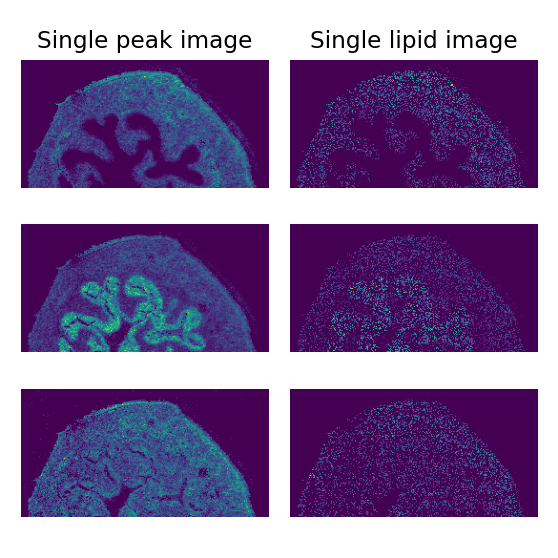

In [28]:
plt.figure(figsize=(4, 4))
plt.subplot(3, 2, 1)
plt.title('Single peak image')
plt.subplot(3, 2, 2)
plt.title('Single lipid image')
for i, n in enumerate(control_lipid_names):
    plt.subplot(3, 2, 1+2*i)
    plt.imshow(profile_bladder_images[i])
    plt.axis('off')
    plt.subplot(3, 2, 2+2*i)
    plt.imshow(control_lipid_images[1][..., i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/peak_assignment/bladder_example_images.png', dpi=300)

The images are rugged, but that's ok for now, because we're interested in peak assignment rather than quantification. The important thing is that they resemble the single peak images in locations where there is some signal.  

In [29]:
for i, s in enumerate(shapes):
    proportions_in_whole[i] /= analyzed_pixels[i]

cerebellum


<IPython.core.display.Javascript object>


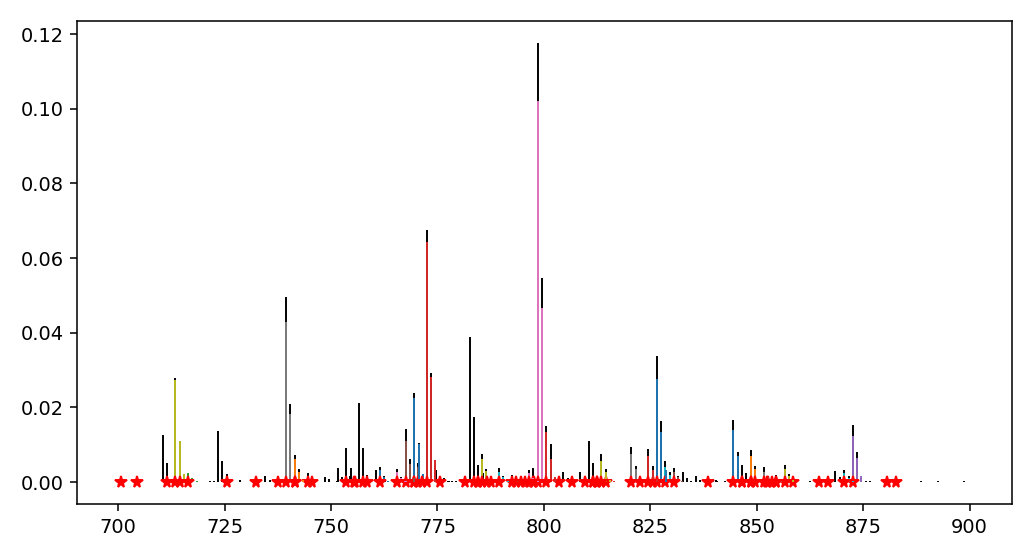

bladder


<IPython.core.display.Javascript object>


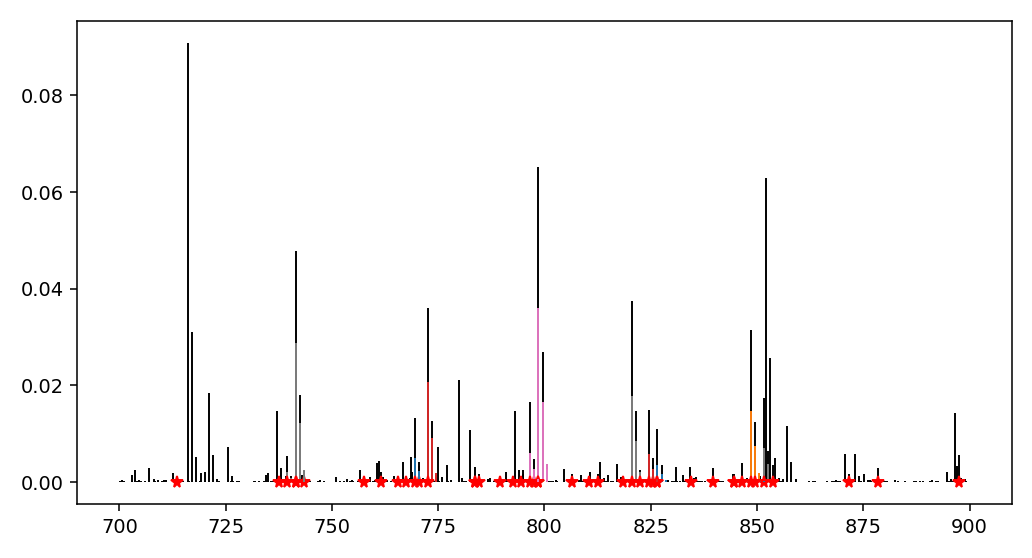

In [30]:
for i, n in enumerate(names):
    print(n)
    plt.figure(figsize=(7.4,4))
    average_spectra[i].plot(profile=False, color='k', show=False)
    for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_whole[i]):
        if p > proportion_threshold:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.tight_layout()
    plt.savefig('Figs/peak_assignment/' + n + '_annotate_then_average_spectrum.png', dpi=300)
    plt.show()

Save the annotation results:

In [31]:
for i,n in enumerate(names):
    with open(n + '_annotation_results.tsv', 'w') as h:
        h.write('\t'.join(['Formula     ', 'Mass', 'Concentration']) + '\n')
        for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_whole[i]):
            if p > proportion_threshold:
                h.write('\t'.join([s.formula, str(round(s.confs[0][0], 4)), str(round(p, 4))]) + '\n')

## Comparing annotations

Reloading results: 

In [32]:
whole_image_annotation = {n: {} for n in names}  # for each image: dict mapping annotated formulas to their proportions
average_spectrum_annotation = {n: {} for n in names}
for i,n in enumerate(names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)
        annotation = [l.strip().split('\t') for l in h if l.strip()]
        for l in annotation:
            whole_image_annotation[n][l[0]] = float(l[2])
    with open(n + '_average_spectrum_annotation_results.tsv') as h:
        next(h)
        annotation = [l.strip().split('\t') for l in h if l.strip()]
        for l in annotation:
            average_spectrum_annotation[n][l[0]] = float(l[2])

In [33]:
for n in names:
    print(n, 'Whole image:', len(whole_image_annotation[n]), 
          'Average spectrum:', len(average_spectrum_annotation[n]), 
          'Both:', len(set(whole_image_annotation[n]).intersection(set(average_spectrum_annotation[n]))))

cerebellum Whole image: 82 Average spectrum: 75 Both: 66
bladder Whole image: 45 Average spectrum: 42 Both: 33


#### The overall correlation between the results of the two annotation strategies:

In [34]:
joint_formula_lists = {n: {} for n in names}
proportion_vectors = {n: {} for n in names}
for i,n in enumerate(names): 
    all_formulas = list(set(whole_image_annotation[n]) | set(average_spectrum_annotation[n]))
    joint_formula_lists[n] = all_formulas
    proportion_vectors[n]['average'] = [average_spectrum_annotation[n][f] if f in average_spectrum_annotation[n] else 0. for f in all_formulas]
    proportion_vectors[n]['whole'] = [whole_image_annotation[n][f] if f in whole_image_annotation[n] else 0. for f in all_formulas]

<IPython.core.display.Javascript object>


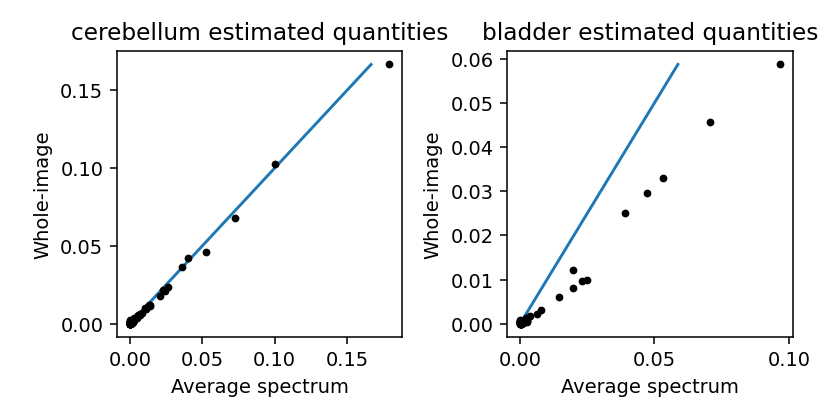

In [35]:
plt.figure(figsize=(6,3))
for i, n in enumerate(names):
    plt.subplot(121+i)
    plt.title(n + ' estimated quantities')
    plt.plot([0, max(proportion_vectors[n]['whole'])], [0, max(proportion_vectors[n]['whole'])])
    plt.plot(proportion_vectors[n]['average'], proportion_vectors[n]['whole'], 'k.')
    
    plt.ylabel('Whole-image')
    plt.xlabel('Average spectrum')
plt.tight_layout()

Check the correlation of annotations (*after discarding lipids absent in both images*, because they artificially inflate the correlation - this is already done)

In [36]:
for i, n in enumerate(names):
    print('Correlation of estimations in', n, 
          np.corrcoef(proportion_vectors[n]['average'], proportion_vectors[n]['whole'])[0,1])

Correlation of estimations in cerebellum 0.9982794831270976
Correlation of estimations in bladder 0.9940943877954695


In [37]:
np.all(np.array(proportion_vectors[n]['average']) + np.array(proportion_vectors[n]['whole'])>0)

True

#### Differences between the annotations

In [38]:
formulas_in_average = {n: set(average_spectrum_annotation[n]) for n in names}
formulas_in_whole = {n: set(whole_image_annotation[n]) for n in names}
venn_dicts = [{'average, then annotate': formulas_in_average[n], 'annotate, then average': formulas_in_whole[n]} for n in names]

cerebellum


<IPython.core.display.Javascript object>


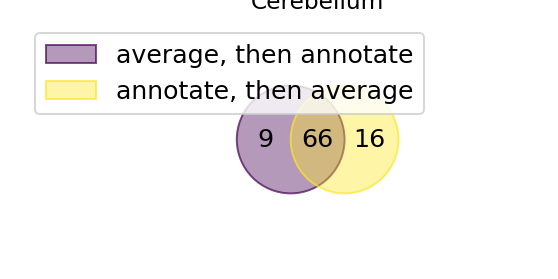

Text(0.5, 1.0, 'Cerebellum')

In [39]:
print(names[0])
venn(venn_dicts[0], figsize=(4,2))
plt.tight_layout()
plt.title('Cerebellum')


bladder


<IPython.core.display.Javascript object>


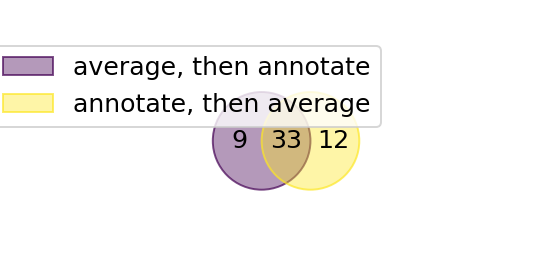

In [40]:
print(names[1])
venn(venn_dicts[1], figsize=(4,2))
plt.show()

Examples of lipids found only when the image was annotated on a per-pixel basis ("annotate -> average" rather than "average -> annotate")

In [41]:
found_only_per_pixel = [sorted([(p, i) for i,p in enumerate(proportions_in_whole[j]) if proportions_in_average[j][i] <=0.0001], reverse=True) for j in range(2)]

In [42]:
found_only_per_pixel = {n: set(whole_image_annotation[n]) - set(average_spectrum_annotation[n]) for n in names}
for n in names:
    sorted_formulas = sorted(found_only_per_pixel[n], key = lambda f: whole_image_annotation[n][f], reverse=True)
    found_only_per_pixel[n] = [(whole_image_annotation[n][f], f) for f in sorted_formulas]

Below the code is old - don't touch for now

#### Lipid class and subclass composition in different annotations and tissues:

In [43]:
wholeimage_annotated_lipid_classes = {}
wholeimage_annotated_lipid_subclasses = {}

for n in names:  
    class_composition = {}
    subclass_composition = {}
    for f in formulas_in_whole[n]:
        f_cls = formula_to_class[f]
        f_sbc = formula_to_subclass[f]
        try:
            class_composition[f_cls].append(f)
        except KeyError:
            class_composition[f_cls] = [f]
            subclass_composition[f_cls] = {f_sbc: [f]}
        else:
            try:
                subclass_composition[f_cls][f_sbc].append(f)
            except KeyError:
                subclass_composition[f_cls][f_sbc] = [f]
    for cls in class_composition:
        class_composition[cls] = set(class_composition[cls])
        for sbc in subclass_composition[cls]:
            subclass_composition[cls][sbc] = set(subclass_composition[cls][sbc])
    wholeimage_annotated_lipid_classes[n] = class_composition
    wholeimage_annotated_lipid_subclasses[n] = subclass_composition

NameError: name 'formula_to_class' is not defined

In [ ]:
for n in names:
    print(n, 'whole image annotation')
    venn(wholeimage_annotated_lipid_classes[n])

In [ ]:
wholeimage_annotated_lipid_subclasses[n]

In [ ]:
found_only_per_pixel[0][:10]

In [ ]:
to_check_bladder = 136
spectrum_hidden_in_bladder = lipid_spectra[to_check_bladder]
spectrum_hidden_in_bladder.confs[0][0]

In [ ]:
hidden_mass_in_bladder = 849.625
closest_average_peak_in_bladder = 849.56

In [ ]:
to_check_cerebellum = 1144
weird = lipid_spectra[to_check_cerebellum]
weird.confs[0][0]

In [ ]:
hidden_mass_in_cerebellum = 846.542
closest_average_peak_in_cerebellum = 846.532

In [ ]:
# hidden_mass_in_cerebellum = 745.478
# closest_average_peak_in_cerebellum = 745.495  # not from average, but from another lipid

In [ ]:
hidden_image = profile_ion_image(cerebellum_profile_image, hidden_mass_in_cerebellum)
closest_image = profile_ion_image(cerebellum_profile_image, closest_average_peak_in_cerebellum)
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.imshow(hidden_image)
plt.title('Hidden')
plt.subplot(122)
plt.imshow(closest_image)
plt.title('Visible')

In [ ]:
hidden_image = profile_ion_image(bladder_profile_image, hidden_mass_in_bladder)
closest_image = profile_ion_image(bladder_profile_image, closest_average_peak_in_bladder)
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.imshow(hidden_image)
plt.title('Hidden')
plt.subplot(122)
plt.imshow(closest_image)
plt.title('Visible')

Notka: Obrazki po dekonwolucji nie musza byc ladne, interesuje nas jedynie istnienie ukrytych pikow 

Po segmentacji zrobic porownanie widm w segmentach odpowiadajacych hidden pikom oraz widm srednich